<a href="https://colab.research.google.com/github/VARADMHETARRAHUL/sentimentanalysis/blob/main/sentimentanaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Importing libraries
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
vocab_size=10000  # Most frequent 10,000 words will be trained
embedding_dim=16  # Each wird has 16 dimension vector
max_length = 100  # Each input sentence will be capped/padded to 100 tokens long.
trunc_type = 'post' # If the sentecne is too long, cut off the end
padding_type = 'post' # If a sentence is too short, add the padding at the end
oov_tok = "<OOV>"  # Special type of tokenizer
training_size = 20000  # First 20,000 samples will be used for training


In [16]:
# Downloading the dataset
!wget --no-check-certificate \
 https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2025-08-17 03:35:27--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.207, 142.251.179.207, 64.233.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2025-08-17 03:35:27 (173 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [25]:
with open("/tmp/sarcasm.json",'r') as f: # opens the downloaded JSON file
  datastore = json.load(f)   # Parses the JSON file in Python list of dictionaries
sentences = [] # To hold the data
labels = []  # To hold the data
for item in datastore:
  sentences.append(item['headline'])  # Collects all the headline
  labels.append(item['is_sarcastic']) # Collects all the labels

In [26]:
training_sentences = sentences[0:training_size]  # Takes the first 20,000 headlines to train
testing_sentences = sentences[training_size:]    # Takes the remaining headlines to test
training_labels = labels[0:training_size]        # Takes first 20,000 labels to train
testing_labels = labels[training_size:]          # Tkes the remaining labels to test


In [27]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)    # Keeps only  top 10,000 frequent words, replces unknown with OOV
tokenizer.fit_on_texts(training_sentences)     #fit_on_texts → scans all training sentences and builds a dictionary mapping words → numbers.

word_index = tokenizer.word_index  # this stores the mapping

training_sequences = tokenizer.texts_to_sequences(training_sentences)   # turns sentences in a list of integers
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding= padding_type, truncating=trunc_type)  # Ensures all sequences are exactly max_length, if too short then add zeroes at the end, if too long then cut the sentence at the ebd

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # Converts your test sentences into padded sequences using the same tokenizer (important so word → index stays consistent).

In [28]:
import numpy as np
training_padded = np.array(training_padded) # Converts the padded training sequence in 2D numpy array, Shape: (20000, 100).
training_labels = np.array(training_labels) # Converts labels (0/1 sarcasm indicators) into a NumPy array. Shape: (2000,).
testing_padded = np.array(testing_padded)   # Converts test sequences into a numpy array. Shape: (6000+, 100).
testing_labels = np.array(testing_labels)   # Test labels as a NumPy array. Shape: (6000+,).

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length), # Input: word indices (integers from the tokenizer).Output: dense vectors of size embedding_dim (16 here).
    # learns to represent the words in such a way that captures semantic meaning
     tf.keras.layers.GlobalAveragePooling1D(),  # Takes average across all 100 word embeddings→reduces each sentence to a single vector of length 16. Shape: (batch_size, 100, 16) → (batch_size, 16)
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - 6ms/step - accuracy: 0.5653 - loss: 0.6774 - val_accuracy: 0.6488 - val_loss: 0.6458
Epoch 2/30
625/625 - 2s - 4ms/step - accuracy: 0.7341 - loss: 0.5453 - val_accuracy: 0.7983 - val_loss: 0.4577
Epoch 3/30
625/625 - 2s - 4ms/step - accuracy: 0.8232 - loss: 0.4028 - val_accuracy: 0.8268 - val_loss: 0.3980
Epoch 4/30
625/625 - 2s - 3ms/step - accuracy: 0.8516 - loss: 0.3459 - val_accuracy: 0.8340 - val_loss: 0.3772
Epoch 5/30
625/625 - 2s - 4ms/step - accuracy: 0.8700 - loss: 0.3136 - val_accuracy: 0.7916 - val_loss: 0.4389
Epoch 6/30
625/625 - 2s - 3ms/step - accuracy: 0.8843 - loss: 0.2787 - val_accuracy: 0.8289 - val_loss: 0.3806
Epoch 7/30
625/625 - 3s - 5ms/step - accuracy: 0.8903 - loss: 0.2616 - val_accuracy: 0.8277 - val_loss: 0.3866
Epoch 8/30
625/625 - 2s - 3ms/step - accuracy: 0.9046 - loss: 0.2357 - val_accuracy: 0.8512 - val_loss: 0.3479
Epoch 9/30
625/625 - 3s - 4ms/step - accuracy: 0.9118 - loss: 0.2185 - val_accuracy: 0.8086 - val_loss: 0.4412
E

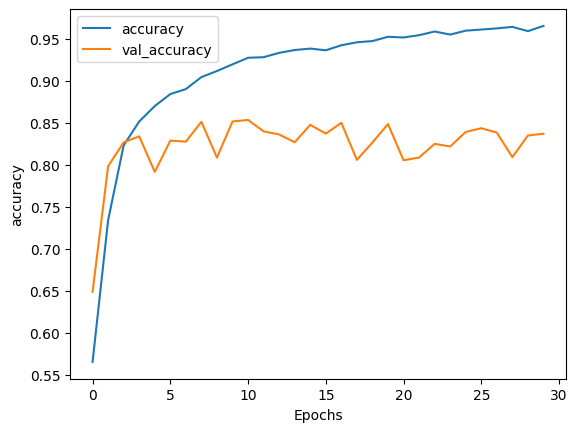

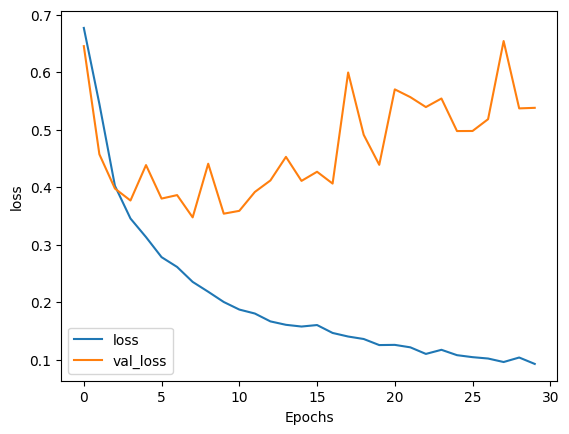

In [33]:
import matplotlib.pyplot as plt

# To plot the accuracy vs validation accuracy
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [35]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [36]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')  # Stores embedding vectors
out_m = io.open('meta.tsv', 'w', encoding='utf-8')  # Stores the corresponding words TSV is tab seperated values  easy for tensorboard projector to read
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [37]:
# To download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# This is for testing
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
[[0.8040626 ]
 [0.01104587]]
